In [1]:

!pip install segmentation_models
#!pip install  segmentation_model==1.0.1

     |████████████████████████████████| 50 kB 5.9 MB/s             


In [2]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


In [3]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Input


In [4]:
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization,MaxPooling2D

In [5]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [7]:
H = 256 # height of image
W = 256 # width of image


# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks


# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x


# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [8]:


RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [10]:
batch_size = 32

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

In [ ]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import VGG16

# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x

# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_vgg16_unet(input_shape,num_classes):
#     """ Input """
#     inputs = Input(input_shape)

#     """ Pre-trained VGG16 Model """
#     vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

#     """ Encoder """
#     s1 = vgg16.get_layer("block1_conv2").output         
#     s2 = vgg16.get_layer("block2_conv2").output         
#     s3 = vgg16.get_layer("block3_conv3").output         
#     s4 = vgg16.get_layer("block4_conv3").output         

#     """ Bridge """
#     b1 = vgg16.get_layer("block5_conv3").output         

#     """ Decoder """
#     d1 = decoder_block(b1, s4, 512)                     
#     d2 = decoder_block(d1, s3, 256)                     
#     d3 = decoder_block(d2, s2, 128)                     
#     d4 = decoder_block(d3, s1, 64)                      

#     """ Output """
#     outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

#     model = Model(inputs, outputs, name="VGG16_U-Net")
#     return model


In [ ]:
    # input_shape = (512, 512, 3)
    # model = build_vgg16_unet(input_shape,4)
    # model.summary()

## Creating U-net Architecture

In [11]:
##########################   Main #####################################

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model


# function to create convolution block
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

'''build_unet it is used to create the U-net architecture.'''
# function to build U-net
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [12]:
# calling build_unet function
model = build_unet((256,256, 3), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Load model and compile

In [13]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models.metrics import iou_score
import datetime, os

""" Hyperparameters """
img_shape = (256, 256, 3)
num_classes = 4
lr = 0.01
batch_size = 32
epochs =1

""" Model """
# model = build_vgg16_unet(img_shape, num_classes)
model = build_unet(img_shape, num_classes)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr), 
              metrics=[iou_score])


train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

## Train model

In [14]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs
    )


244/244 [==============================] - 385s 2s/step - loss: 0.0788 - iou_score: 0.1989 - val_loss: 1.0419 - val_iou_score: 0.1338


In [15]:
model.save('model.h5')

In [16]:
# from te
import cv2
import matplotlib.pyplot as plt
MODEL_PATH = '/kaggle/working/model.h5'


# model = load_model(MODEL_PATH,compile=False)


def predict_mask(img_path):
    H = 256
    W = 256
    num_classes = 4

#     input_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     input_img = cv2.imread(img_path)
    input_img = cv2.resize(img_path, (W, H))
    input_img = input_img / 255.0
    input_img = input_img.astype(np.float32)

    ## Prediction
    pred_mask = model.predict(np.expand_dims(input_img, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask * (255/num_classes)
    pred_mask = pred_mask.astype(np.int32)
    pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=2)

    input_img = input_img * 255.0
    input_img = input_img.astype(np.int32)

    return input_img, pred_mask

import base64
from io import BytesIO


def to_data_uri(pil_img):
    data = BytesIO()
#     pil_img.save(data, "PNG")
    data64 = base64.b64encode(data.getvalue())
    return u'data:img/png;base64,'+data64.decode('utf-8')



In [25]:

input_img = cv2.imread('/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/TCAM15.png',cv2.IMREAD_COLOR)
# input_img = cv2.imread('/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0001.png',cv2.IMREAD_COLOR)
input_img, pred_mask = predict_mask(input_img)
input_image = tf.keras.preprocessing.image.array_to_img(input_img)
input_image_uri = to_data_uri(input_img)

mask_image = tf.keras.preprocessing.image.array_to_img(pred_mask)
mask_uri = to_data_uri(mask_image)

# cv2.imshow(pred_img)


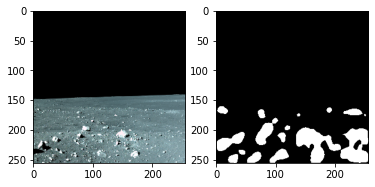

In [26]:
plt.subplot(1,2,1)
plt.imshow(input_img)
plt.subplot(1,2,2)
plt.imshow(mask_image)
plt.show()